<a href="https://colab.research.google.com/github/Rizwanali324/Deep_learning_images_Classification/blob/main/Emotion_Recognation_98%25(FER).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle


In [5]:
from google.colab import files
import os

# Upload the Kaggle API key file
uploaded = files.upload()

# Name of the uploaded file
filename = next(iter(uploaded))

# Create the Kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the Kaggle API key to the Kaggle directory
os.rename(filename, '/root/.kaggle/kaggle.json')

# Ensure the file is in place and permissions are set correctly
os.chmod('/root/.kaggle/kaggle.json', 600)

print("File moved successfully!")


Saving kaggle (1).json to kaggle (1) (2).json
File moved successfully!


In [6]:
!!kaggle datasets download -d shawon10/ckplus

['Downloading ckplus.zip to /content',
 '',
 '  0% 0.00/3.63M [00:00<?, ?B/s]',
 ' 28% 1.00M/3.63M [00:00<00:02, 1.11MB/s]',
 ' 55% 2.00M/3.63M [00:01<00:00, 2.18MB/s]',
 '100% 3.63M/3.63M [00:01<00:00, 4.19MB/s]',
 '',
 '100% 3.63M/3.63M [00:01<00:00, 3.08MB/s]']

In [7]:
!unzip ckplus.zip


Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_00000024.png  
  inflating: CK+48/anger/S029_001_00000017.png  
  inflating: CK+48/anger/S029_001_00000018.png  

In [8]:
import os
import numpy as np
import matplotlib.image as mpimg

import random
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
# Define the main path to the dataset
dataset_path = '/content/CK+48'

# Function to count the number of images in each set and list subfolder classes
def count_images_and_classes(path):
    class_counts = {}
    total_count = 0
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            # Count the number of images in each subfolder
            count = len(os.listdir(class_path))
            total_count += count
            class_counts[class_name] = count
    return total_count, class_counts

# Count images and list classes in the dataset
total_count, class_counts = count_images_and_classes(dataset_path)
print("Total number of images:", total_count)
print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Total number of images: 981
Number of images in each class:
happy: 207
disgust: 177
sadness: 84
contempt: 54
anger: 135
fear: 75
surprise: 249



Class: happy


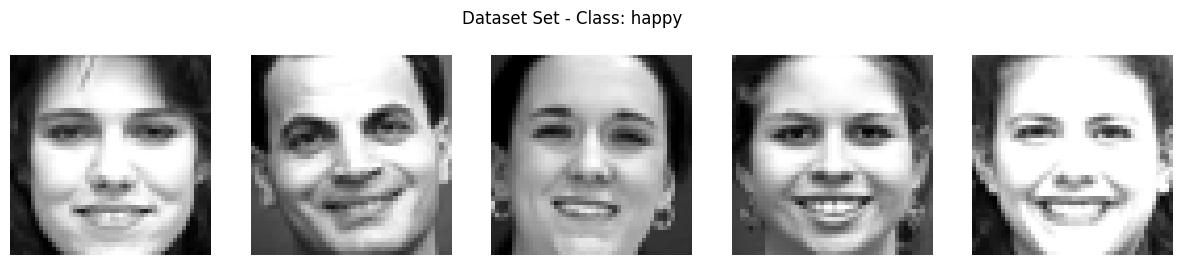


Class: disgust


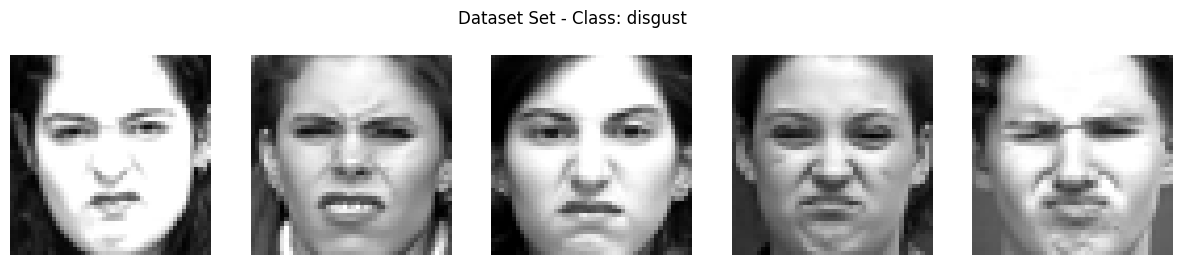


Class: sadness


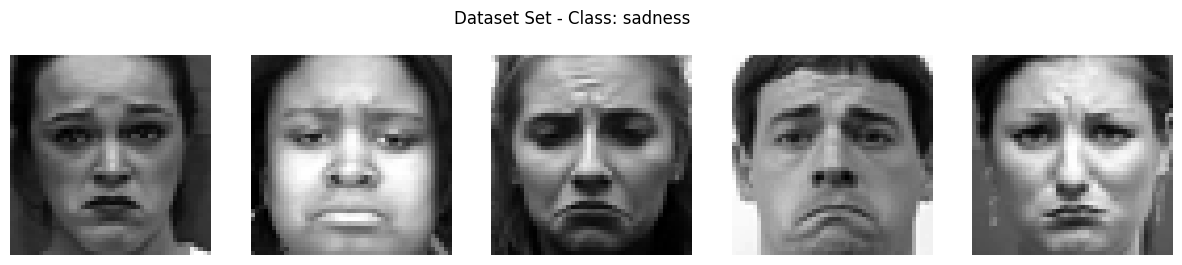


Class: contempt


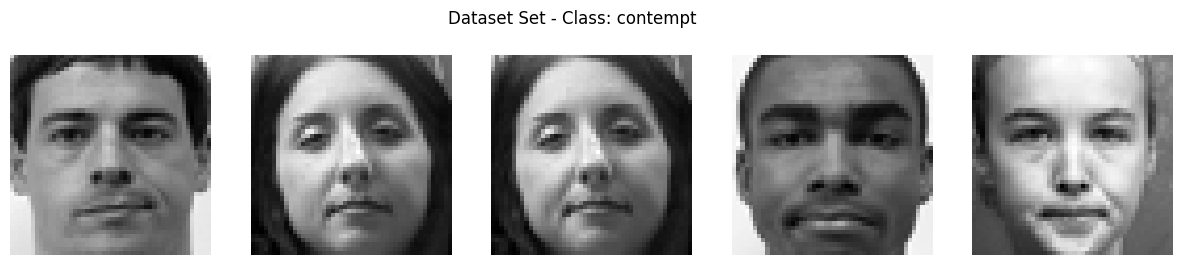


Class: anger


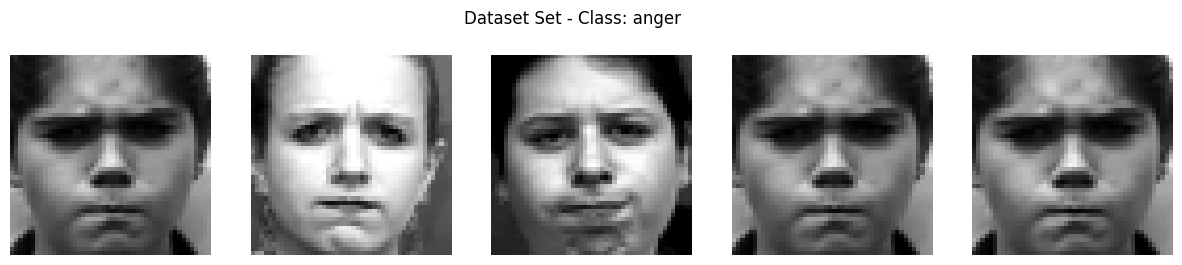


Class: fear


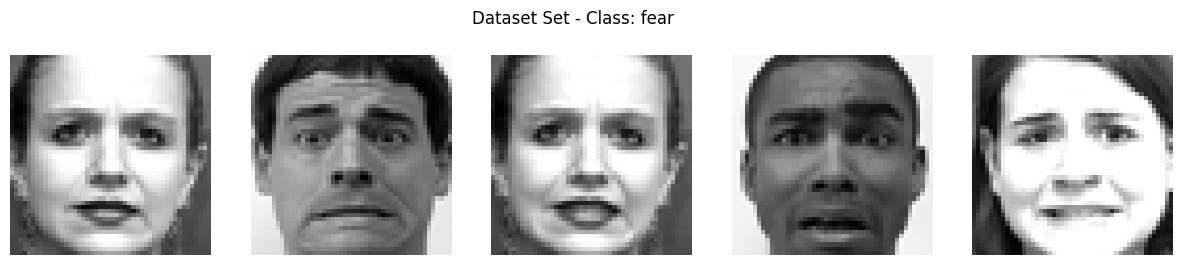


Class: surprise


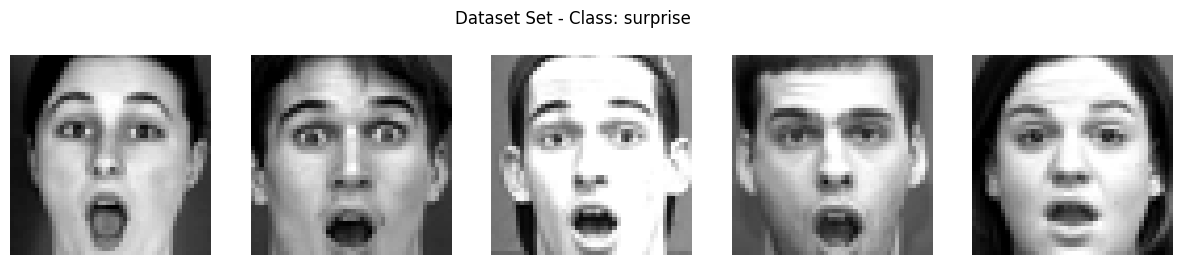

In [11]:
# Function to count the number of images in each class and display random images
def display_image_counts_bar_and_pie(path, set_name):
    class_counts = {}
    total_count = 0
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # List of colors for each bar
    color_index = 0
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            # Count the number of images in each class
            count = len(os.listdir(class_path))
            total_count += count
            class_counts[class_name] = count

            # Display 5 random images from each class
            print(f"\nClass: {class_name}")
            image_files = os.listdir(class_path)
            random.shuffle(image_files)
            plt.figure(figsize=(15, 3))
            for i in range(5):
                image_file = random.choice(image_files)
                image_path = os.path.join(class_path, image_file)
                image = mpimg.imread(image_path)
                plt.subplot(1, 5, i + 1)
                plt.imshow(image, cmap='gray')  # Assume images are grayscale
                plt.axis('off')
            plt.suptitle(f"{set_name} Set - Class: {class_name}")
            plt.show()

    # Create bar chart
    fig_bar = go.Figure()
    for class_name, count in class_counts.items():
        fig_bar.add_trace(go.Bar(x=[class_name], y=[count], name=class_name, marker_color=colors[color_index]))
        color_index = (color_index + 1) % len(colors)  # Increment color index and wrap around if necessary
    fig_bar.update_layout(title_text=f"Image Counts in {set_name} Set")

    # Create pie chart
    fig_pie = go.Figure()
    fig_pie.add_trace(go.Pie(labels=list(class_counts.keys()), values=list(class_counts.values()), name=set_name))
    fig_pie.update_layout(title_text=f"Class Distribution in {set_name} Set")

    # Show the plots
    fig_bar.show()
    fig_pie.show()

# Call the function to display images, bar chart, and pie chart
display_image_counts_bar_and_pie(dataset_path, "Dataset")

In [12]:
# Function to split data into train and test sets
def split_train_test_data(path, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            # Get paths of all images in the class
            class_image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]
            image_paths.extend(class_image_paths)
            labels.extend([class_name] * len(class_image_paths))
    # Split data into train and test sets
    return train_test_split(image_paths, labels, test_size=test_size, random_state=random_state)

# Split the dataset into train and test sets
train_image_paths, test_image_paths, train_labels, test_labels = split_train_test_data(dataset_path)

# Print the number of images in train and test sets
print("\nNumber of images in train set:", len(train_image_paths))
print("Number of images in test set:", len(test_image_paths))


Number of images in train set: 784
Number of images in test set: 197


In [14]:

# Load and preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return img_array

# Split the dataset into train and test sets
train_image_paths, test_image_paths, train_labels, test_labels = split_train_test_data(dataset_path)

# Preprocess train and test images
train_images = np.array([preprocess_image(img_path) for img_path in train_image_paths])
test_images = np.array([preprocess_image(img_path) for img_path in test_image_paths])

# One-hot encode the labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)
num_classes = len(label_encoder.classes_)

In [16]:

# Load pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the ResNet50 base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

In [17]:

# Train the model
history = model.fit(train_images, train_labels_encoded,
                    batch_size=32,
                    epochs=100,
                    validation_data=(test_images, test_labels_encoded),
                    callbacks=[checkpoint, reduce_lr, early_stopping])


Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 2.1028 - accuracy: 0.4375
Epoch 1: val_loss improved from inf to 1.00750, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



25/25 [==============================] - 17s 344ms/step - loss: 2.1028 - accuracy: 0.4375 - val_loss: 1.0075 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.8051 - accuracy: 0.7194
Epoch 2: val_loss improved from 1.00750 to 0.69875, saving model to best_model.h5
25/25 [==============================] - 4s 155ms/step - loss: 0.8051 - accuracy: 0.7194 - val_loss: 0.6988 - val_accuracy: 0.7766 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6075 - accuracy: 0.8023
Epoch 3: val_loss improved from 0.69875 to 0.52018, saving model to best_model.h5
25/25 [==============================] - 4s 151ms/step - loss: 0.6075 - accuracy: 0.8023 - val_loss: 0.5202 - val_accuracy: 0.8629 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.4558 - accuracy: 0.8457
Epoch 4: val_loss improved from 0.52018 to 0.42803, saving model to best_model.h5
25/25 [=============================

In [18]:
# Extract training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Create subplots
fig = go.Figure()

# Add training and validation loss traces
fig.add_trace(go.Scatter(x=list(epochs), y=train_loss, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_loss, mode='lines', name='Validation Loss'))

# Update layout for loss subplot
fig.update_layout(title_text='Training and Validation Losses',
                  xaxis_title='Epochs',
                  yaxis_title='Loss',
                  template='plotly_white',
                  width=800,
                  height=400,
                  margin=dict(l=20, r=20, t=40, b=20),
                  yaxis=dict(exponentformat='none'))

# Add training and validation accuracy traces
fig.add_trace(go.Scatter(x=list(epochs), y=train_acc, mode='lines', name='Training Accuracy'))
fig.add_trace(go.Scatter(x=list(epochs), y=val_acc, mode='lines', name='Validation Accuracy'))

# Update layout for accuracy subplot
fig.update_layout(yaxis2=dict(title='Accuracy', side='right', overlaying='y'))

# Show the plot
fig.show()


In [19]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_images, test_labels_encoded)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

7/7 [==============================] - 1s 84ms/step - loss: 0.0242 - accuracy: 1.0000
Test Loss: 0.024188656359910965, Test Accuracy: 1.0


In [20]:
# Make predictions on the test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Reverse label encoding for predicted and true labels
predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels)
test_labels_decoded = label_encoder.inverse_transform(test_labels_encoded)

# Print the classification report
print(classification_report(test_labels_decoded, predicted_labels_decoded))

7/7 [==============================] - 1s 87ms/step
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        29
    contempt       1.00      1.00      1.00         9
     disgust       1.00      1.00      1.00        44
        fear       1.00      1.00      1.00        17
       happy       1.00      1.00      1.00        34
     sadness       1.00      1.00      1.00        19
    surprise       1.00      1.00      1.00        45

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [21]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels_decoded, predicted_labels_decoded, labels=label_encoder.classes_)

# Create Plotly heatmap
fig = go.Figure(data=go.Heatmap(z=conf_matrix,
                                 x=label_encoder.classes_,
                                 y=label_encoder.classes_,
                                 colorscale='Blues',
                                 hoverongaps=False))

# Add annotations to the heatmap
for i in range(len(label_encoder.classes_)):
    for j in range(len(label_encoder.classes_)):
        fig.add_annotation(x=label_encoder.classes_[j], y=label_encoder.classes_[i],
                           text=str(conf_matrix[i][j]),
                           showarrow=False,
                           font=dict(color='white' if conf_matrix[i][j] > np.max(conf_matrix) / 2 else 'black'))

# Customize layout
fig.update_layout(title='Confusion Matrix',
                  xaxis_title='Predicted labels',
                  yaxis_title='True labels',
                  xaxis=dict(tickangle=45),
                  yaxis=dict(tickangle=45))

# Show plot
fig.show()

In [22]:
from keras.models import load_model

# Save the model architecture as JSON
model_json = model.to_json()
with open("best_model.json", "w") as json_file:
    json_file.write(model_json)

In [23]:
from google.colab import files

# Provide the path to the file you want to download
file_path = '/content/best_model.h5'

# Trigger the download
files.download(file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>